<a href="https://colab.research.google.com/github/MayuBhattu/FNO/blob/main/FNO_Long_Range_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import glob
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
USER_PATHS = {
    "MAYURESH": {
        "data_path": "/content/drive/MyDrive/CS229 Project FNO/final_generation/simulation_results_final/",
         "output_path": "/content/drive/MyDrive/CS229 Project FNO/tensors long range/",
    },
    "SHAUNAK": {
        "data_path": "/content/drive/MyDrive/CS229 Project FNO/final_generation/simulation_results_final/",
        "output_path": "/content/drive/MyDrive/CS229 Project FNO/tensors new/",
    }
    }

In [4]:
user = "MAYURESH"
data_path = USER_PATHS[user]["data_path"]
output_path = USER_PATHS[user]["output_path"]

In [5]:
static_files = sorted(glob.glob(data_path + "static_data_sim*.csv"))
time_series_files = sorted(glob.glob(data_path + "time_series_data_sim*.csv"))

print(len(static_files))
print(len(time_series_files))

assert(len(static_files) == len(time_series_files))
os.makedirs(output_path, exist_ok=True)

len(static_files)

1000
1000


1000

In [6]:
num_points = 21  # Grid resolution
num_steps = 200  # Time steps
T_context = 10  # Number of past frames used as input
input_channels = 6+T_context  # x, y, IC, Dirichlet mask, Neumann mask, BC values, last 3 frames

In [ ]:
for i, (static_file, time_series_file) in enumerate(
    tqdm(zip(static_files, time_series_files), total=len(static_files), desc="Generating Tensors", dynamic_ncols=True)
):
    static_df = pd.read_csv(static_file)
    time_series_df = pd.read_csv(time_series_file)

    ic = static_df["Initial_Condition"].values.reshape(num_points, num_points)
    dirichlet_mask = static_df["Dirichlet_Mask"].values.reshape(num_points, num_points)
    neumann_mask = static_df["Neumann_Mask"].values.reshape(num_points, num_points)
    bc_values = static_df["BC_Value"].values.reshape(num_points, num_points)

    u_solution = time_series_df["u(x,y,t)"].values.reshape(num_steps, num_points, num_points)
    # u_solution = u_solution[:, :-1, :-1]  # Reshape into 20x20 (not needed anymore)

    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num_points), np.linspace(0, 1, num_points))

    local_X, local_Y = [], []

    input_tensor = np.stack([
        x_grid, y_grid, ic,
        dirichlet_mask, neumann_mask, bc_values,
        *u_solution[:T_context]
    ], axis=0)  # Shape: (9, 20, 20)

    output_tensor = u_solution[T_context:]  # Shape: (20, 20)
    local_X.append(input_tensor)
    local_Y.append(output_tensor)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(np.array(local_X), dtype=torch.float32)  # (steps, 9, 20, 20)
    Y_tensor = torch.tensor(np.array(local_Y), dtype=torch.float32)  # (steps, 20, 20)

    # ================= SAVE TO .PT =================
    torch.save(X_tensor, os.path.join(output_path, f"X_sim{i}.pt"))
    torch.save(Y_tensor, os.path.join(output_path, f"Y_sim{i}.pt"))

print("✅ All simulations saved as .pt files!")

Generating Tensors:   1%|          | 10/1000 [02:13<3:39:56, 13.33s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
import numpy as np
import torch

seed = 42  # Chosen seed for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)

# Apply CUDA-specific seed only if using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [8]:
train_path = output_path

x_files = sorted(glob.glob(train_path + "X_sim*.pt"))
y_files = sorted(glob.glob(train_path + "Y_sim*.pt"))

# Ensure both lists are of the same length
assert len(x_files) == len(y_files), "Mismatch in number of X and Y files!"

# Zip, shuffle, and unzip
file_pairs = list(zip(x_files, y_files))
random.shuffle(file_pairs)  # Shuffle the pairs together
x_files, y_files = zip(*file_pairs)  # Unzip back into separate lists

# Convert back to lists (since zip() returns tuples)
x_files = list(x_files)
y_files = list(y_files)

n_train = 600
n_test = 200
n_valid = 1000 - n_train - n_test

batch_size = 64

# from concurrent.futures import ThreadPoolExecutor

# def load_tensor(file):
#     return torch.load(file, weights_only=False)

# # Use threading to load multiple files in parallel
# with ThreadPoolExecutor() as executor:
#     X_train_tensors = list(executor.map(load_tensor, x_files[:n_train]))

# X_train = torch.cat(X_train_tensors, dim=0)
X_train = torch.cat([torch.load(f, weights_only=False) for f in x_files[:n_train]], dim=0)
Y_train = torch.cat([torch.load(f, weights_only=False) for f in y_files[:n_train]], dim=0)

X_val = torch.cat([torch.load(f, weights_only=False) for f in x_files[n_train:n_train+n_valid]], dim=0)
Y_val = torch.cat([torch.load(f, weights_only=False) for f in y_files[n_train:n_train+n_valid]], dim=0)

X_test = torch.cat([torch.load(f, weights_only=False) for f in x_files[n_train+n_valid:]], dim=0)
Y_test = torch.cat([torch.load(f, weights_only=False) for f in y_files[n_train+n_valid:]], dim=0)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_val, Y_val)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Loaded X_train: {X_train.shape}, Y_train: {Y_train.shape}")
# No. of simulations * (Examples per simulation)  = 600 * 196 = 117,600

Loaded X_train: torch.Size([600, 16, 21, 21]), Y_train: torch.Size([600, 190, 21, 21])


In [9]:
# SpectralConv2d refers to the implementation of one Fourier layer
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        x_ft = torch.fft.rfftn(x, dim=[-2,-1])
        out_ft = torch.zeros_like(x_ft)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x

# SimpleBlock2d contains our entire architecture
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(SimpleBlock2d, self).__init__()
        # P-layer: convert to higher dimensional "width" channel space
        self.fc0 = nn.Linear(input_channels, width)
        self.fc_res = nn.Linear(T_context, num_steps - T_context)

        # Fourier Layers
        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)

        # Local linear transforms W to be applied in parallel to Fourier Layers
        self.w0 = nn.Conv1d(width, width, 1)
        self.w1 = nn.Conv1d(width, width, 1)
        self.w2 = nn.Conv1d(width, width, 1)

        # Q-layer(/s): NN to project channel space back to a target dimension
        # Q) Why 128? Why not 1 directly?
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, num_steps- T_context)

    def forward(self, x):
        batchsize, _, size_x, size_y = x.shape
        # P-layer
        #x_res = self.fc_res(x.permute(0, 2, 3, 1)[..., -T_context:]).squeeze()

        x = self.fc0(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        # First Fourier layer
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, -1, size_x * size_y)).view(batchsize, -1, size_x, size_y)
        x =  F.relu(x1 + x2)

        # Second Fourier layer
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, -1, size_x * size_y)).view(batchsize, -1, size_x, size_y)
        x = F.relu(x1 + x2)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, -1, size_x * size_y)).view(batchsize, -1, size_x, size_y)
        x = F.relu(x1 + x2)

        # Q-layer(/s)
        x = self.fc2(F.relu(self.fc1(x.permute(0, 2, 3, 1)))).permute(0, 3, 1, 2)
        return x #+ x_res

# Wrapper function for implementing our architecture
class FNO(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO, self).__init__()
        self.fno = SimpleBlock2d(modes1, modes2, width)

    def forward(self, x):
        return self.fno(x)

In [10]:
def custom_loss(outputs, targets, inputs, lambda_d=0.1, lambda_n=0.1):
    """
    Custom loss function incorporating Dirichlet and Neumann boundary conditions.

    Parameters:
    - outputs: Model predictions (batch_size, timesteps, grid_x, grid_y)
    - targets: Ground truth (batch_size, timesteps, grid_x, grid_y)
    - inputs: Input tensor (contains boundary masks and values)
    - lambda_d: Weight for Dirichlet loss
    - lambda_n: Weight for Neumann loss

    Returns:
    - Total loss combining MSE, Dirichlet, and Neumann constraints.
    """
    mse_loss = F.mse_loss(outputs, targets)

    # Extract boundary information from inputs
    dirichlet_mask = inputs[:, 3, :, :].unsqueeze(1)  # (batch_size, 1, grid_x, grid_y)
    neumann_mask = inputs[:, 4, :, :].unsqueeze(1)  # (batch_size, 1, grid_x, grid_y)
    bc_values = inputs[:, 5, :, :].unsqueeze(1)  # (batch_size, 1, grid_x, grid_y) - Stores flux g(x,y)

    # Expand masks to match outputs shape
    dirichlet_mask = dirichlet_mask.expand(-1, outputs.shape[1], -1, -1)
    bc_values = bc_values.expand(-1, outputs.shape[1], -1, -1)

    # Dirichlet Loss: Enforce output values at Dirichlet points
    dirichlet_loss = F.mse_loss(outputs * dirichlet_mask, bc_values * dirichlet_mask)

    # Neumann Loss: Compute full spatial gradients
    dx = 1.0 / outputs.shape[2]  # Assuming uniform grid
    dy = 1.0 / outputs.shape[3]

    # Compute finite difference gradients (centered differences where possible)
    grad_x = torch.zeros_like(outputs)
    grad_y = torch.zeros_like(outputs)

    # Forward difference for left boundary
    grad_x[:, :, 0, :] = (outputs[:, :, 0, :] - outputs[:, :, 1, :]) / dx
    # Backward difference for right boundary
    grad_x[:, :, -1, :] = (outputs[:, :, -1, :] - outputs[:, :, -2, :]) / dx

    # Forward difference for bottom boundary
    grad_y[:, :, :, 0] = (outputs[:, :, :, 0] - outputs[:, :, :, 1]) / dy
    # Backward difference for top boundary
    grad_y[:, :, :, -1] = (outputs[:, :, :, -1] - outputs[:, :, :, -2]) / dy

    # Compute total Neumann loss at boundary points
    grad_norm = grad_x + grad_y  # Combine all gradient components
    neumann_loss = F.mse_loss(neumann_mask * grad_norm, neumann_mask * bc_values)

    # Total Loss
    total_loss = mse_loss + lambda_d * dirichlet_loss + lambda_n * neumann_loss

    return total_loss


In [70]:
modes, width = 11, 20 # modes > 11 don't work - maybe related to grid resolution being 20x20
num_epochs = 2000

model = FNO(modes, modes, width).to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
valid_loss_history = []

train_relative_loss_history = []
valid_relative_loss_history = []

window_size = 5  # Number of epochs for moving average
loss_threshold = 0.25  # Stopping threshold for moving average loss
val_loss_window = []  # Track last `window_size` validation losses

for epoch in range(num_epochs):
    total_loss = 0
    total_relative_loss = 0  # Initialize relative loss sum

    # === Training Step ===
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = custom_loss(outputs, targets, inputs, lambda_d=0.1, lambda_n=0.1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

        # Compute relative loss
        relative_loss = torch.mean(torch.abs(outputs - targets) / (torch.abs(targets) + 1e-8))  # Avoid division by zero
        total_relative_loss += relative_loss.item()

    epoch_loss = total_loss / len(train_loader)
    epoch_loss_rel = total_relative_loss / len(train_loader)  # Average relative loss over batches
    train_loss_history.append(epoch_loss)
    train_relative_loss_history.append(epoch_loss_rel)  # Store relative loss

    # === Validation Step ===
    model.eval()
    total_val_loss = 0
    relative_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in valid_loader:
            val_inputs, val_targets = val_inputs.to("cuda"), val_targets.to("cuda")
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

            # Compute relative loss
            relative_loss = torch.mean(torch.abs(val_outputs - val_targets) / (torch.abs(val_targets) + 1e-8))  # Avoid division by zero
            relative_val_loss += relative_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_loss_rel = relative_val_loss / len(valid_loader)
    valid_loss_history.append(avg_val_loss) # Store for plotting
    valid_relative_loss_history.append(avg_val_loss_rel)

    val_loss_window.append(avg_val_loss_rel)
    if len(val_loss_window) > window_size:
        val_loss_window.pop(0)  # Keep only last `window_size` losses

    # Compute moving average loss
    moving_avg_loss = sum(val_loss_window) / len(val_loss_window)

    print(f"Moving Avg Val Loss: {moving_avg_loss:.6f}")

    # Stop training if moving average validation loss is below threshold
    if moving_avg_loss < loss_threshold:
        print(f"Stopping early: Moving Avg Val Loss ({moving_avg_loss:.6f}) < Threshold ({loss_threshold})")
        break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Rel Train Loss: {epoch_loss_rel*100:.2f}%, Rel Val Loss: {avg_val_loss_rel*100:.2f}%")



Streaming output truncated to the last 5000 lines.
Epoch 334/2000, Train Loss: 0.001628, Val Loss: 0.055004
Epoch 334/2000, Rel Train Loss: 74.41%, Rel Val Loss: 90.13%
Moving Avg Val Loss: 0.971851
Epoch 335/2000, Train Loss: 0.001834, Val Loss: 0.063739
Epoch 335/2000, Rel Train Loss: 87.20%, Rel Val Loss: 114.02%
Moving Avg Val Loss: 0.957622
Epoch 336/2000, Train Loss: 0.003681, Val Loss: 0.054997
Epoch 336/2000, Rel Train Loss: 111.27%, Rel Val Loss: 88.99%
Moving Avg Val Loss: 0.952977
Epoch 337/2000, Train Loss: 0.002664, Val Loss: 0.057600
Epoch 337/2000, Rel Train Loss: 99.52%, Rel Val Loss: 90.94%
Moving Avg Val Loss: 1.018041
Epoch 338/2000, Train Loss: 0.002699, Val Loss: 0.058185
Epoch 338/2000, Rel Train Loss: 129.28%, Rel Val Loss: 124.95%
Moving Avg Val Loss: 1.010547
Epoch 339/2000, Train Loss: 0.003940, Val Loss: 0.059669
Epoch 339/2000, Rel Train Loss: 90.99%, Rel Val Loss: 86.38%
Moving Avg Val Loss: 0.973018
Epoch 340/2000, Train Loss: 0.002453, Val Loss: 0.056154


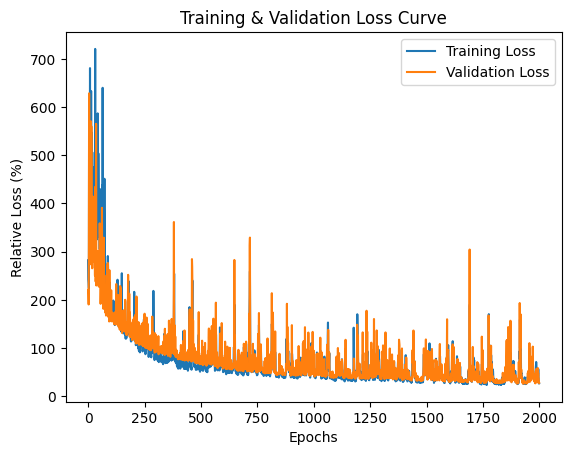

In [83]:
# === Plot Train & Validation Loss === (Add this after training loop)


# Plot the updated lists
plt.plot([100* x for x in train_relative_loss_history], label="Training Loss")
plt.plot([100 * x for x in valid_relative_loss_history], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Relative Loss (%)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

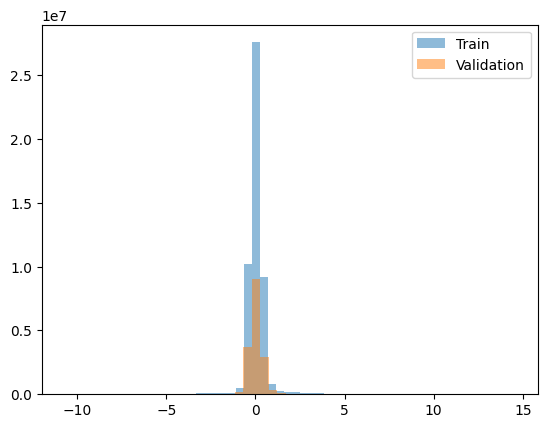

In [84]:
plt.hist(Y_train.flatten().cpu().numpy(), bins=50, alpha=0.5, label="Train")
plt.hist(Y_val.flatten().cpu().numpy(), bins=50, alpha=0.5, label="Validation")
plt.legend()
plt.show()

In [85]:
# === Test Model Performance ===
model.eval()  # Set model to evaluation mode
total_test_loss = 0
total_absolute_error = 0
total_relative_error = 0
epsilon = 1e-8  # To avoid division by zero

with torch.no_grad():
    for test_inputs, test_targets in test_loader:
        test_inputs, test_targets = test_inputs.to("cuda"), test_targets.to("cuda")
        test_outputs = model(test_inputs)

        # Compute MSE Loss
        test_loss = criterion(test_outputs, test_targets)
        total_test_loss += test_loss.item()

        # Compute MAE (Mean Absolute Error)
        mae = torch.abs(test_outputs - test_targets).mean().item()
        total_absolute_error += mae

        # Compute Relative Error
        relative_error = (torch.abs(test_outputs - test_targets) / (torch.abs(test_targets) + epsilon)).mean().item()
        total_relative_error += relative_error

# Compute average test loss
avg_test_loss = total_test_loss / len(test_loader)
avg_test_mae = total_absolute_error / len(test_loader)
avg_test_relative_error = total_relative_error / len(test_loader)

print(f" Test MSE Loss: {avg_test_loss:.6f}")
print(f" Test MAE (Mean Absolute Error): {avg_test_mae:.6f}")
print(f" Test Relative Error: {avg_test_relative_error:.6f}")


 Test MSE Loss: 0.004179
 Test MAE (Mean Absolute Error): 0.019485
 Test Relative Error: 0.277595


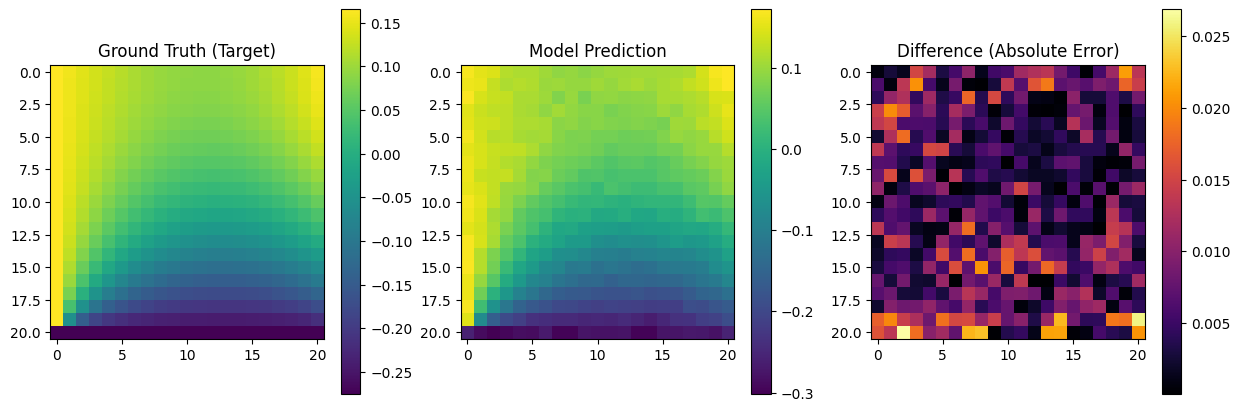

In [96]:
import matplotlib.pyplot as plt
import torch
import numpy.random as random

# === Select a random test sample ===
# Select a random test sample
sample_idx = random.randint(0, len(test_dataset) - 1) # Change this index to visualize different test samples

# Get the test input and target
test_sample, target_sample = test_dataset[sample_idx]  # Assuming test_dataset is a TensorDataset
test_sample = test_sample.unsqueeze(0).to("cuda")  # Add batch dimension

# Get model prediction
model.eval()
with torch.no_grad():
    prediction = model(test_sample).cpu().squeeze(0)  # Remove batch dimension

# Move target to CPU for plotting
target_sample = target_sample.cpu()

# Compute the difference (absolute error)
# Compute the relative error
epsilon = 1e-8  # Small constant to prevent division by zero
difference = torch.abs(prediction - target_sample) #/ (torch.abs(target_sample) + epsilon)


# === Plotting ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the target
im1 = axes[0].imshow(target_sample[-1].numpy(), cmap="viridis")
axes[0].set_title("Ground Truth (Target)")
plt.colorbar(im1, ax=axes[0])

# Plot the prediction
im2 = axes[1].imshow(prediction[-1].numpy(), cmap="viridis")
axes[1].set_title("Model Prediction")
plt.colorbar(im2, ax=axes[1])

# Plot the absolute error
im3 = axes[2].imshow( difference[-1].numpy(), cmap="inferno")
axes[2].set_title("Difference (Absolute Error)")
plt.colorbar(im3, ax=axes[2])

plt.show()
